In [ ]:
import os
import sys
# import spacy
import torch
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import concurrent.futures
import spacy
from textblob import TextBlob
from collections import defaultdict
from transformers import AutoModel, AutoTokenizer
from scipy.stats import rv_discrete, lognorm, entropy
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import math

current_directory = '/Users/daryltay/Library/Mobile Documents/com~apple~CloudDocs/NUS Masters/Modules/CS5340 Uncertainty in AI Modelling/Project'
os.chdir(current_directory)

print(os.getcwd())

/Users/daryltay/miniconda3/envs/cs5340/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/daryltay/Library/Mobile Documents/com~apple~CloudDocs/NUS Masters/Modules/CS5340 Uncertainty in AI Modelling/Project


## SECTION 1: Define directories for import and export of data & Ingest raw datasets

In [ ]:
reviewcontent_path = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/reviewContent" #359052 rows
reviewrating_path = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/reviewGraph"
reviewrating_path = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/reviewGraph"
metadata_path = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/metadata"

similarity0_path = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/similarity_df_data.csv"
similarity_path = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/similarity_df_data_scores.csv"
similarity_path_final = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/collusiveness_score.pkl"


In [ ]:
def read_txt_file(file_path):
  """Reads the content of a text file.

  Args:
    file_path: The path to the text file.

  Returns:
    A list of strings, where each string represents a line from the file.
  """
  with open(file_path, 'r') as f:
    lines = f.readlines()
  return lines

# --------------------------------------------------------------------
# --------------------- read review content file ---------------------
# --------------------------------------------------------------------

reviewcontent_filelist = []
reviewcontent_file = read_txt_file(reviewcontent_path)
for lines in reviewcontent_file:
  lines = lines.replace("\n", "")
  lines = lines.split('\t')
  reviewcontent_filelist.append(lines)

reviewcontent_df = pd.DataFrame(reviewcontent_filelist, columns= ['user_id', 'product_id', 'date', 'review'])
reviewcontent_df['date'] = pd.to_datetime(reviewcontent_df['date'], format = "%Y-%m-%d")

# --------------------------------------------------------------------
# --------------------- read review rating file ----------------------
# --------------------------------------------------------------------

reviewrating_filelist = []
reviewrating_file = read_txt_file(reviewrating_path)
for lines in reviewrating_file:
  lines = lines.replace("\n", "")
  lines = lines.split('\t')
  reviewrating_filelist.append(lines)

reviewrating_df = pd.DataFrame(reviewrating_filelist, columns= ['user_id', 'product_id', 'rating']) #359052 rows

# --------------------------------------------------------------------
# --------------------- read metadata file -------------------------
# --------------------------------------------------------------------
metadata = []
metadata_file = read_txt_file(metadata_path)
for lines in metadata_file:
  lines = lines.replace("\n", "")
  lines = lines.split('\t')
  metadata.append(lines)

metadata_df = pd.DataFrame(metadata, columns = ['user_id', 'product_id', 'rating', 'label', 'date'])
metadata_df['rating'] = metadata_df['rating'].astype(float)
metadata_df['daydiff'] = metadata_df['date'].apply(lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d") - datetime.datetime(2004, 1, 1)).days)
metadata_df = metadata_df[['user_id','product_id','rating','daydiff']]


## SECTION 2: Prior Computation

In [ ]:
#!/usr/bin/env python3
"""
collueagle_priors.py

Compute ColluEagle reviewer priors (Neighbor Tightness) with optional GPU acceleration,
merging into a reviews DataFrame and saving to CSV, using multithreading for parallelism.
Usage:
    1. Install dependencies:
         pip install pandas scipy tqdm torch
    2. Set INPUT_REVIEW_CSV, INPUT_RATING_CSV, OUTPUT_CSV paths.
    3. Ensure review CSV has: userid, product, date, review.
    4. Ensure rating CSV has: userid, product, rating.
    5. Run: python collueagle_priors.py
"""
import pandas as pd
import itertools
import math
from scipy.stats import norm
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch

# --- Configuration --------------------------------------------------------
INPUT_REVIEW_CSV = 'data/reviewContent.csv'
INPUT_RATING_CSV = 'data/ratings.csv'
OUTPUT_CSV       = 'data/reviews_with_priors.csv'
USER_COL, ITEM_COL, DATE_COL, REVIEW_COL, RATING_COL = (
    'userid','product','date','review','rating'
)
SIGMA1      = 86400.0  # 1 day in seconds
SIGMA2      = 1.0      # rating-diff scale
NUM_WORKERS = 4        # for ThreadPoolExecutor
GROUPS      = []       # custom lists of reviewers for cliques

# --- GPU detection --------------------------------------------------------
USE_GPU = torch.cuda.is_available()
DEVICE  = torch.device('cuda') if USE_GPU else torch.device('cpu')
if USE_GPU:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    def compute_collusiveness(reviews_i, reviews_j, sigma1, sigma2):
        common = list(set(reviews_i) & set(reviews_j))
        if not common:
            return 0.0
        ts_i = torch.tensor([reviews_i[p]['timestamp'].timestamp() for p in common], device=DEVICE)
        ts_j = torch.tensor([reviews_j[p]['timestamp'].timestamp() for p in common], device=DEVICE)
        dt   = ts_i - ts_j
        r_i  = torch.tensor([reviews_i[p]['rating'] for p in common], device=DEVICE)
        r_j  = torch.tensor([reviews_j[p]['rating'] for p in common], device=DEVICE)
        dp   = r_i - r_j
        cdf_t = 0.5 * (1 - torch.erf(torch.abs(dt)/(sigma1*math.sqrt(2))))
        cdf_p = 0.5 * (1 - torch.erf(torch.abs(dp)/(sigma2*math.sqrt(2))))
        sims  = 4 * cdf_t * cdf_p
        return sims.max().item()
else:
    print("Using CPU for computations")
    def compute_collusiveness(reviews_i, reviews_j, sigma1, sigma2):
        max_sim = 0.0
        for pid, rec_i in reviews_i.items():
            rec_j = reviews_j.get(pid)
            if rec_j:
                dt = (rec_i['timestamp'] - rec_j['timestamp']).total_seconds()
                dp = rec_i['rating'] - rec_j['rating']
                sim = 4 * norm.cdf(-abs(dt)/sigma1) * norm.cdf(-abs(dp)/sigma2)
                max_sim = max(max_sim, sim)
        return max_sim

# --- ColluEagle core ------------------------------------------------------
def compute_NT(group, reviewer_reviews, sigma1, sigma2):
    n = len(group)
    if n < 2:
        return 0.0
    total = 0.0
    for i, j in itertools.combinations(group, 2):
        collu = compute_collusiveness(
            reviewer_reviews[i], reviewer_reviews[j], sigma1, sigma2
        )
        Pi, Pj = set(reviewer_reviews[i]), set(reviewer_reviews[j])
        total += collu * (len(Pi & Pj) / len(Pi | Pj))
    penalty = 1.0 / (1.0 + math.exp(-(n - 2)))
    return (total / math.comb(n, 2)) * penalty

def _compute_group_nt(group, reviewer_reviews):
    return group, compute_NT(group, reviewer_reviews, SIGMA1, SIGMA2)

# --- Main pipeline --------------------------------------------------------
if __name__ == '__main__':
    # 1. Load and merge data
    reviews = pd.read_csv(
        INPUT_REVIEW_CSV, sep='\t', header=None,
        names=[USER_COL, ITEM_COL, DATE_COL, REVIEW_COL]
    )
    reviews[DATE_COL] = pd.to_datetime(reviews[DATE_COL], errors='coerce')
    ratings = pd.read_csv(
        INPUT_RATING_CSV, sep='\t', header=None,
        names=[USER_COL, ITEM_COL, RATING_COL, '_c4', '_c5'], usecols=[0,1,2]
    )
    df = pd.merge(
        reviews, ratings[[USER_COL, ITEM_COL, RATING_COL]],
        on=[USER_COL, ITEM_COL], how='left'
    )
    df[RATING_COL].fillna(0.0, inplace=True)

    # 2. Build nested dict per reviewer
    reviewer_reviews = {}
    for user, grp in tqdm(df.groupby(USER_COL), desc="Building reviewer_reviews"):
        reviewer_reviews[user] = {
            row[ITEM_COL]: {'timestamp': row[DATE_COL], 'rating': row[RATING_COL]}
            for _, row in grp.iterrows()
        }

    # 3. Determine groups
    groups = GROUPS or [list(reviewer_reviews.keys())]

    # 4. Compute priors in parallel via threads
    priors = {}
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        futures = [executor.submit(_compute_group_nt, grp, reviewer_reviews) for grp in groups]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Computing NT priors"):
            grp, score = future.result()
            for uid in grp:
                priors[uid] = score

    # 5. Merge and save result
    prior_df = pd.DataFrame.from_dict(priors, orient='index', columns=['prior'])
    prior_df.index.name = USER_COL
    prior_df.reset_index(inplace=True)
    final_df = df.merge(prior_df, on=USER_COL)
    print(final_df[[USER_COL, ITEM_COL, RATING_COL, 'prior']].head())
    final_df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved to {OUTPUT_CSV}")

## SECTION 3: calculation of pairwise similarities among reviewers
#### subsection 3.1: Extraction of text features & embeddings from review text, and difference in ratings and day of review

In [ ]:
import multiprocessing as mp
from collections import defaultdict
from tqdm import tqdm
import concurrent.futures
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ✅ Compute similarity with fast dictionary lookup
def compute_similarity(ri, rj, review_lookup):
    """Compute similarity between two reviewers using precomputed dictionary."""
    daydiff_i, rating_i, text_i, analysis1, emb1 = review_lookup[ri]
    daydiff_j, rating_j, text_j, analysis2, emb2 = review_lookup[rj]
    t = abs(daydiff_i - daydiff_j)
    r = abs(rating_i - rating_j)
    review_similarity = compare_reviews_extracted(analysis1, analysis2, emb1, emb2)
    return {
        'user_id1': ri[0], 'user_id2': rj[0], 'product_id': ri[1],
        'daydiff': t, 'ratingdiff': r,
        'feature_similarity': float(review_similarity['Feature Similarity']),
        'bert_similarity': review_similarity['BERT Similarity']
    }


def compare_reviews_extracted(analysis1, analysis2, emb1, emb2):
    bert_similarity = cosine_similarity(emb1, emb2)[0][0]
    # Compute feature similarity (Euclidean distance normalization)
    feature_vector1 = np.array(list(analysis1.values()))
    feature_vector2 = np.array(list(analysis2.values()))
    feature_similarity = 1 - np.linalg.norm(feature_vector1 - feature_vector2) / np.linalg.norm(feature_vector1 + feature_vector2)
    # Final combined similarity score
    combined_similarity = (bert_similarity + feature_similarity) / 2
    return {
        "BERT Similarity": bert_similarity,
        "Feature Similarity": feature_similarity,
        "Combined Similarity": combined_similarity
    }

# ✅ Global variable to store review data (avoid multiprocessing issues)
review_lookup = {}

# ✅ Function to create a normal dictionary (not using Manager)
def build_review_lookup(review_df):
    """Precompute a normal dictionary for fast lookups (avoid Manager issues)."""
    return {
        (row['user_id'], row['product_id']): (
            row['daydiff'], row['rating'], row['text'], row['text_features'], row['embeddings']
        )
        for _, row in review_df.iterrows()
    }
# ✅ Fast Pair Generation
def generate_pairs(twDictProduct):
    """Generate reviewer pairs efficiently."""
    for pid, reviewers in twDictProduct.items():
        yield from itertools.combinations(reviewers, 2)

# ✅ Optimized Compute Similarity Wrapper for `map()`
def compute_similarity_map(pair):
    """Wrapper for compute_similarity that handles multiple pairs."""
    ri, rj = pair
    return compute_similarity(ri, rj)

# ✅ Function to initialize workers with global `review_lookup`
def init_worker(shared_lookup):
    global review_lookup
    review_lookup = shared_lookup


def compute_similarity_worker(pair):
    """Compute similarity between two reviewers using global shared lookup."""
    ri, rj, pid = pair  # Unpack the tuple (user1, user2, product_id)
    global review_lookup  # Use global lookup initialized in worker

    if (ri, pid) not in review_lookup or (rj, pid) not in review_lookup:
        return None  # Skip if data is missing

    # Retrieve data for both reviewers
    daydiff_i, rating_i, text_i, analysis1, emb1 = review_lookup[(ri, pid)]
    daydiff_j, rating_j, text_j, analysis2, emb2 = review_lookup[(rj, pid)]

    # Compute differences
    t = abs(daydiff_i - daydiff_j)
    r = abs(rating_i - rating_j)

    # Compute review similarities
    review_similarity = compare_reviews_extracted(analysis1, analysis2, emb1, emb2)

    return {
        'user_id1': ri, 'user_id2': rj, 'product_id': pid,  # ✅ Include product_id
        'daydiff': t, 'ratingdiff': r,
        'feature_similarity': float(review_similarity['Feature Similarity']),
        'bert_similarity': review_similarity['BERT Similarity']
    }

def process_product_batch(product_batch, twDictProduct):
    """Process a batch of product IDs."""
    reviewer_pairs = [
        (ri, rj, pid)
        for pid in product_batch
        for ri, rj in itertools.combinations(twDictProduct[pid], 2)
    ]

    results = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=4, initializer=init_worker, initargs=(review_lookup,)) as executor:
        for result in tqdm(executor.map(compute_similarity_worker, reviewer_pairs), total=len(reviewer_pairs), desc=f"Processing Batch {product_batch[0]}-{product_batch[-1]}"):
            if result is not None:
                results.append(result)
    return results

def construct_similarity_matrix(review_df, min_days=200, max_days=4200, batch_size=100):
    """Construct similarity matrix using optimized batch processing of product IDs."""
    twDictProduct = defaultdict(set)

    # ✅ Step 1: Build Product-Reviewer Mapping
    print("Building reviewer-product dictionaries...")
    for _, row in tqdm(review_df.iterrows(), total=len(review_df)):
        if min_days <= row['daydiff'] <= max_days:
            rid, pid = row['user_id'], row['product_id']
            twDictProduct[pid].add(rid)

    # ✅ Step 2: Precompute Review Lookup Dictionary
    print("Precomputing fast review lookup dictionary...")
    global review_lookup
    review_lookup = {
        (row['user_id'], row['product_id']): (
            row['daydiff'], row['rating'], row['text'], row['text_features'], row['embeddings']
        )
        for _, row in review_df.iterrows()
    }

    # ✅ Step 3: Process Product Batches
    product_ids = list(twDictProduct.keys())
    batches = [product_ids[i:i+batch_size] for i in range(0, len(product_ids), batch_size)]

    similarity_list = []
    for batch in tqdm(batches, desc="Processing Product Batches"):
        similarity_list.extend(process_product_batch(batch, twDictProduct))

    return similarity_list

import pandas as pd
import os

def split_review_df_by_product(review_df, batch_size=30, save_dir="review_batches"):
    """Splits review_df into smaller subsamples by partitioning product_id into batches."""

    # ✅ Step 1: Get unique product IDs
    product_ids = review_df['product_id'].unique()

    # ✅ Step 2: Create batches of product IDs
    product_batches = [product_ids[i:i+batch_size] for i in range(0, len(product_ids), batch_size)]
    print(len(product_batches))
    # ✅ Step 3: Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    batch_filenames = []
    for i, batch in enumerate(product_batches):
        # ✅ Step 4: Filter reviews belonging to the current batch of product IDs
        batch_df = review_df[review_df['product_id'].isin(batch)]
        similarity_list = construct_similarity_matrix(batch_df, batch_size=10)
        similarity_df = pd.DataFrame(similarity_list)
        # ✅ Step 5: Save each batch separately (CSV or Pickle for efficiency)
        batch_filename = os.path.join(save_dir, f"similarity_df_data_{i+1}.pkl")
        similarity_df.to_pickle(batch_filename)  # Use Pickle (faster than CSV for large data)

        print(f"✅ Saved batch {i+1} with {len(batch_df)} rows → {batch_filename}")
        batch_filenames.append(batch_filename)

    return batch_filenames  # Return the list of saved batch files

# ✅ Run multiprocessing code inside `if __name__ == "__main__"` (macOS Fix)
# if __name__ == "__main__":
reviews_df = pd.read_pickle("reviews_df.pkl")
split_review_df_by_product(reviews_df, batch_size=100, save_dir="review_batches")

## SECTION 3: calculation of pairwise similarities among reviewers
#### subsection 3.2: Visualization of empirical distribution of differences for each feature

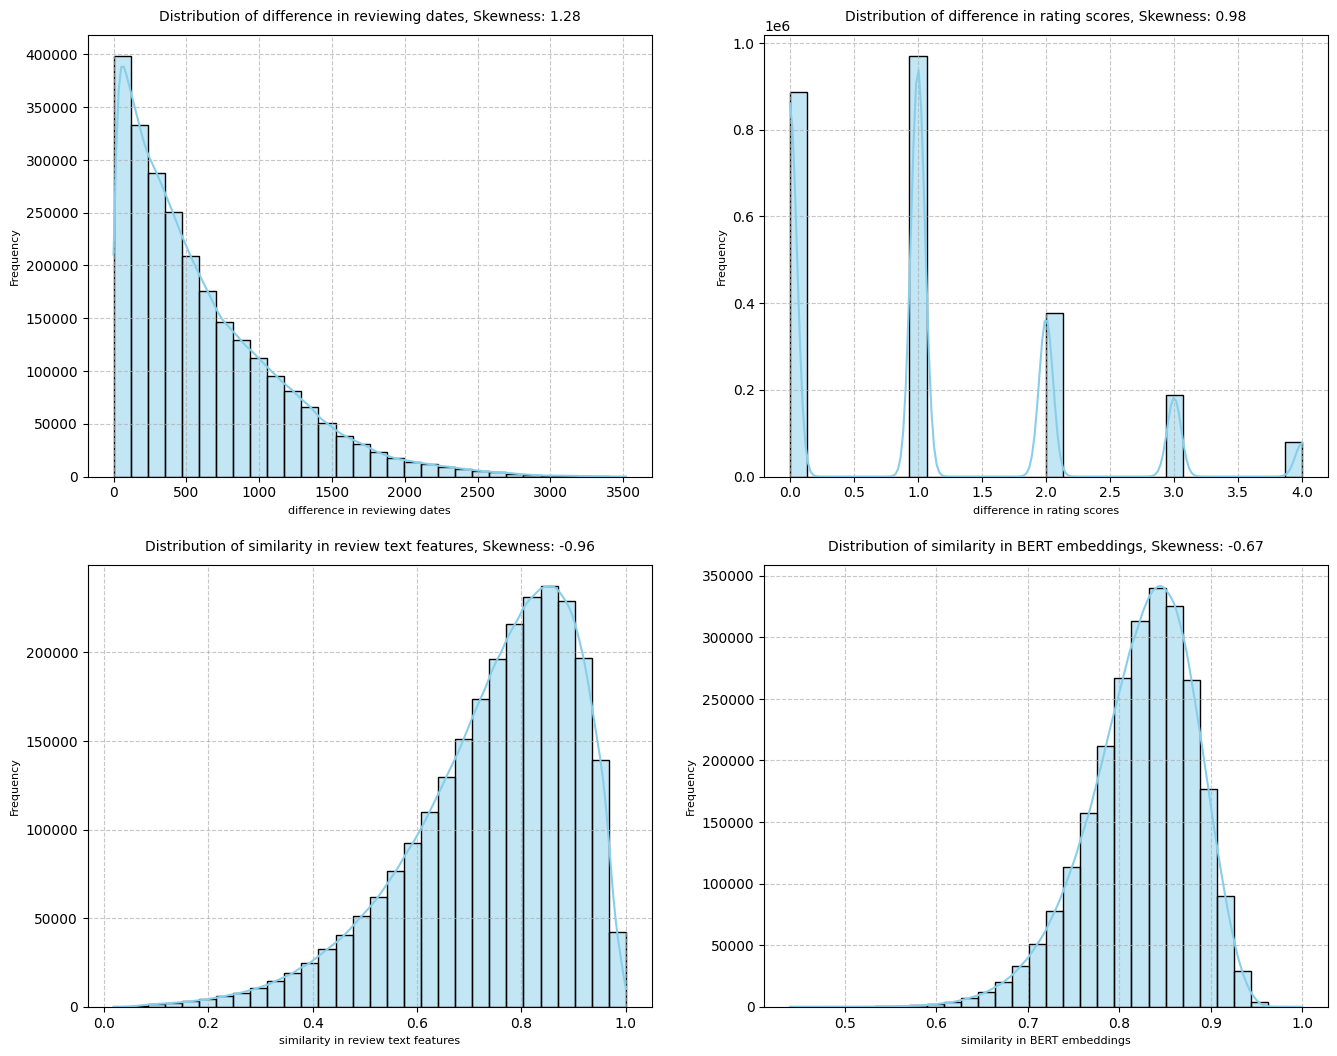

In [ ]:

similarity_df = pd.read_csv(similarity0_path) #'user_id1', 'user_id2', 'product_id', 'daydiff', 'ratingdiff', 'feature_similarity', 'bert_similarity'

title_dict = {
            'ratingdiff': "difference in rating scores",
            'daydiff': "difference in reviewing dates",
            "feature_similarity": "similarity in review text features",
            "bert_similarity": "similarity in BERT embeddings"
        }

# Create 2x2 grid of subplots with proper figure size
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Increased figure size for clarity
axes = axes.ravel()  # Flatten 2x2 array to 1D for easier iteration

# List of columns to plot in order
columns = ['daydiff', 'ratingdiff', 'feature_similarity', 'bert_similarity']

# Iterate through columns and axes simultaneously
for ax, plot_col in zip(axes, columns):
    # Plot histogram with KDE
    sns.histplot(
        data=similarity_df,
        x=plot_col,
        kde=True,
        ax=ax,
        bins=30,
        color='skyblue',
        edgecolor='black'
    )

    # Format labels and title
    ax.set_xlabel(title_dict[plot_col], fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.set_title(f"Distribution of {title_dict[plot_col]}, Skewness: {round(similarity_df[plot_col].skew(), 2)}", fontsize=10, pad=10)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.subplots_adjust(top=0.92)  # Adjust top spacing for titles
plt.show()


## SECTION 3: calculation of pairwise similarities among reviewers
#### subsection 3.3: Fitting of distributions for calculation of combined similarities score

In [ ]:
def create_rating_model(rating_differences):
    """
    Create a discrete probability model for rating differences with normalized PMF.

    Parameters
    ----------
    rating_differences : array-like
        Array of observed rating differences between reviewer pairs

    Returns
    -------
    rating_model : rv_discrete
        Discrete probability distribution of rating differences
    normalized_pmf : function
        Min-max scaled probability mass function returning values in [0, 1]
    """
    # Get unique rating differences and their frequencies
    unique_ratings, counts = np.unique(rating_differences, return_counts=True)

    # Convert counts to probabilities
    probabilities = counts / counts.sum()  # Sum to 1 normalization

    # Create discrete probability distribution
    rating_model = rv_discrete(name="rating_diff", values=(unique_ratings, probabilities))

    # Compute PMF bounds for scaling
    pmf_values = np.array([rating_model.pmf(r) for r in unique_ratings])
    min_pmf, max_pmf = pmf_values.min(), pmf_values.max()

    def normalized_pmf(r):
        """
        Min-max normalized PMF ensuring non-negative outputs.

        Parameters
        ----------
        r : int
            Rating difference value

        Returns
        -------
        float
            Normalized probability in [0, 1] range
        """
        # Prevent division by zero with small epsilon
        normalized_value = (rating_model.pmf(r) - min_pmf) / (max_pmf - min_pmf + 1e-9)
        return max(0, normalized_value)  # Force non-negative probabilities

    return rating_model, normalized_pmf

def lognormal_pdf(x, mu, sigma, min_lognorm, max_lognorm):
    """
    Compute min-max scaled log-normal PDF values.

    Parameters
    ----------
    x : float
        Input value (time difference)
    mu : float
        Log-normal location parameter
    sigma : float
        Log-normal scale parameter
    min_lognorm : float
        Minimum PDF value for scaling
    max_lognorm : float
        Maximum PDF value for scaling

    Returns
    -------
    float
        Scaled probability in [0, 1] range
    """
    # Compute raw log-normal probability
    prob = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

    # Apply min-max scaling with epsilon to prevent division by zero
    return (prob - min_lognorm) / (max_lognorm - min_lognorm + 1e-9)

def compute_similarity(t, r, rating_model, normalized_pmf, mu_t, sigma_t, min_lognorm, max_lognorm):
    """
    Compute combined similarity score from time and rating probabilities.

    Parameters
    ----------
    t : float
        Time difference between reviews
    r : int
        Rating difference between reviews
    rating_model : rv_discrete
        Rating difference probability model
    normalized_pmf : function
        Scaled rating PMF function
    mu_t : float
        Log-normal location parameter for time differences
    sigma_t : float
        Log-normal scale parameter for time differences
    min_lognorm : float
        Minimum log-normal PDF value for scaling
    max_lognorm : float
        Maximum log-normal PDF value for scaling

    Returns
    -------
    tuple
        (prob_time_scaled, prob_rate_scaled) - scaled probabilities
    """
    # Compute scaled time probability
    prob_time_scaled = lognormal_pdf(t, mu_t, sigma_t, min_lognorm, max_lognorm)
    # Compute scaled rating probability
    prob_rate_scaled = normalized_pmf(r)
    return prob_time_scaled, prob_rate_scaled

# === Load and Process Data ===
rating_differences = np.array(similarity_df['ratingdiff'], dtype=np.int64)
rating_model, normalized_pmf = create_rating_model(rating_differences)

epsilon = 1e-9
time_differences = np.array(similarity_df['daydiff'], dtype=np.float64)
log_time = np.log(time_differences + epsilon)

# Fit Log-Normal Distribution (Estimate Mu & Sigma)
mu_t, sigma_t = np.mean(log_time), np.std(log_time)

# Find Min & Max Log-Normal PDF values for scaling
time_range = np.linspace(time_differences.min(), time_differences.max(), 1000)
lognorm_probs = lognorm.pdf(time_range, s=sigma_t, scale=np.exp(mu_t))
min_lognorm, max_lognorm = lognorm_probs.min(), lognorm_probs.max()

# === Apply Similarity Computation to DataFrame ===
similarity_df['daydiff_log','rating_diff_log'] = similarity_df.apply(
    lambda row: compute_similarity(
        t=row['daydiff'],
        r=row['ratingdiff'],
        rating_model=rating_model,
        normalized_pmf=normalized_pmf,
        mu_t=mu_t,
        sigma_t=sigma_t,
        min_lognorm=min_lognorm,
        max_lognorm=max_lognorm
    ),
    axis=1
)

similarity_df['daydiff_log'] = similarity_df['daydiff_log','rating_diff_log'].apply(lambda x: x[0])
similarity_df['rating_diff_log'] = similarity_df['daydiff_log','rating_diff_log'].apply(lambda x: x[1])


## SECTION 3: calculation of pairwise similarities among reviewers
#### subsection 3.4: weighting of features based on entropy, and final output of similarity scores

In [ ]:
def compute_entropy(df):
    """
    Compute Shannon entropy of a dataset using probability distribution of unique rows.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset where each row represents an observation

    Returns
    -------
    float
        Shannon entropy in bits (log base 2)
    """
    # Calculate probability distribution of unique rows
    value_counts = df.value_counts(normalize=True)  # Get normalized frequencies

    # Compute entropy using scipy's entropy function with base 2
    return entropy(value_counts, base=2)  # Returns H(X) in bits

def entropy_based_weighting(df):
    """
    Compute feature importance weights using entropy reduction methodology.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with numerical features (columns)

    Returns
    -------
    dict
        Normalized feature weights where:
        - Keys are feature names
        - Values are weights ∈ [0,1] summing to 1
        - Higher weights indicate features whose removal *increases* entropy more
    """
    # Baseline entropy with all features
    full_entropy = compute_entropy(df)  # H(full)
    feature_weights = {}

    for feature in df.columns:
        # Create dataset without current feature
        df_reduced = df.drop(columns=[feature])  # Remove one feature

        # Compute entropy of reduced dataset
        reduced_entropy = compute_entropy(df_reduced)  # H(reduced)

        # Calculate entropy change (could be negative if removal increases entropy)
        entropy_reduction = full_entropy - reduced_entropy  # ΔH = H(full) - H(reduced)

        # Weight is inverse of entropy reduction (smaller ΔH → higher weight)
        # Add epsilon to prevent division by zero
        feature_weights[feature] = 1 / (entropy_reduction + 1e-6)  # 1/(ΔH + ε)

    # Normalize weights to probability distribution
    total_weight = sum(feature_weights.values())  # Sum of raw weights
    feature_weights = {k: v / total_weight for k, v in feature_weights.items()}  # ∑weights = 1

    return feature_weights

# Compute entropy-based feature weights
feature_weights = entropy_based_weighting(similarity_df[['daydiff_log','rating_diff_log','feature_similarity','bert_similarity']])
print("Feature Weights:", feature_weights)

# Compute similarity
similarity_df['similarity_score'] = (feature_weights['daydiff_log'] * similarity_df['daydiff_log'] +
                                     feature_weights['rating_diff_log'] * similarity_df['rating_diff_log'] +
                                     feature_weights['feature_similarity'] * similarity_df['feature_similarity'] +
                                     feature_weights['bert_similarity'] * similarity_df['bert_similarity']
                                    )


Feature Weights: {'daydiff_log': np.float64(0.00034341144947961115), 'rating_diff_log': np.float64(0.7192535104740456), 'feature_similarity': np.float64(0.0036246356242257993), 'bert_similarity': np.float64(0.2767784424522489)}


## SECTION 3: calculation of pairwise similarities among reviewers
#### 3.5: Visualization of final similarity scores

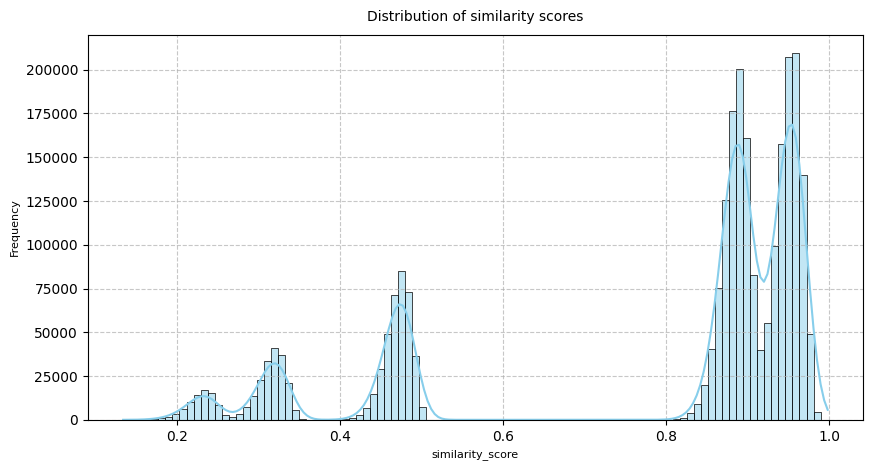

In [ ]:
# Create 2x2 grid of subplots with proper figure size
fig, axes = plt.subplots(1, 1, figsize=(10, 5))  # Increased figure size for clarity

# List of columns to plot in order
plot_col = 'similarity_score'

# Plot histogram with KDE
sns.histplot(
    data=similarity_df,
    x=plot_col,
    kde=True,
    ax=axes,
    bins=100,
    color='skyblue',
    edgecolor='black'
)

# Format labels and title
axes.set_xlabel(plot_col, fontsize=8)
axes.set_ylabel('Frequency', fontsize=8)
axes.set_title(f"Distribution of similarity scores", fontsize=10, pad=10)
axes.grid(True, linestyle='--', alpha=0.7)

plt.show()

## SECTION 4: visualization of reviewer-product graph and reviewer-reviewer graph

2025-03-29 22:40:10.524446 -- COMMENCE GRAPH CREATION


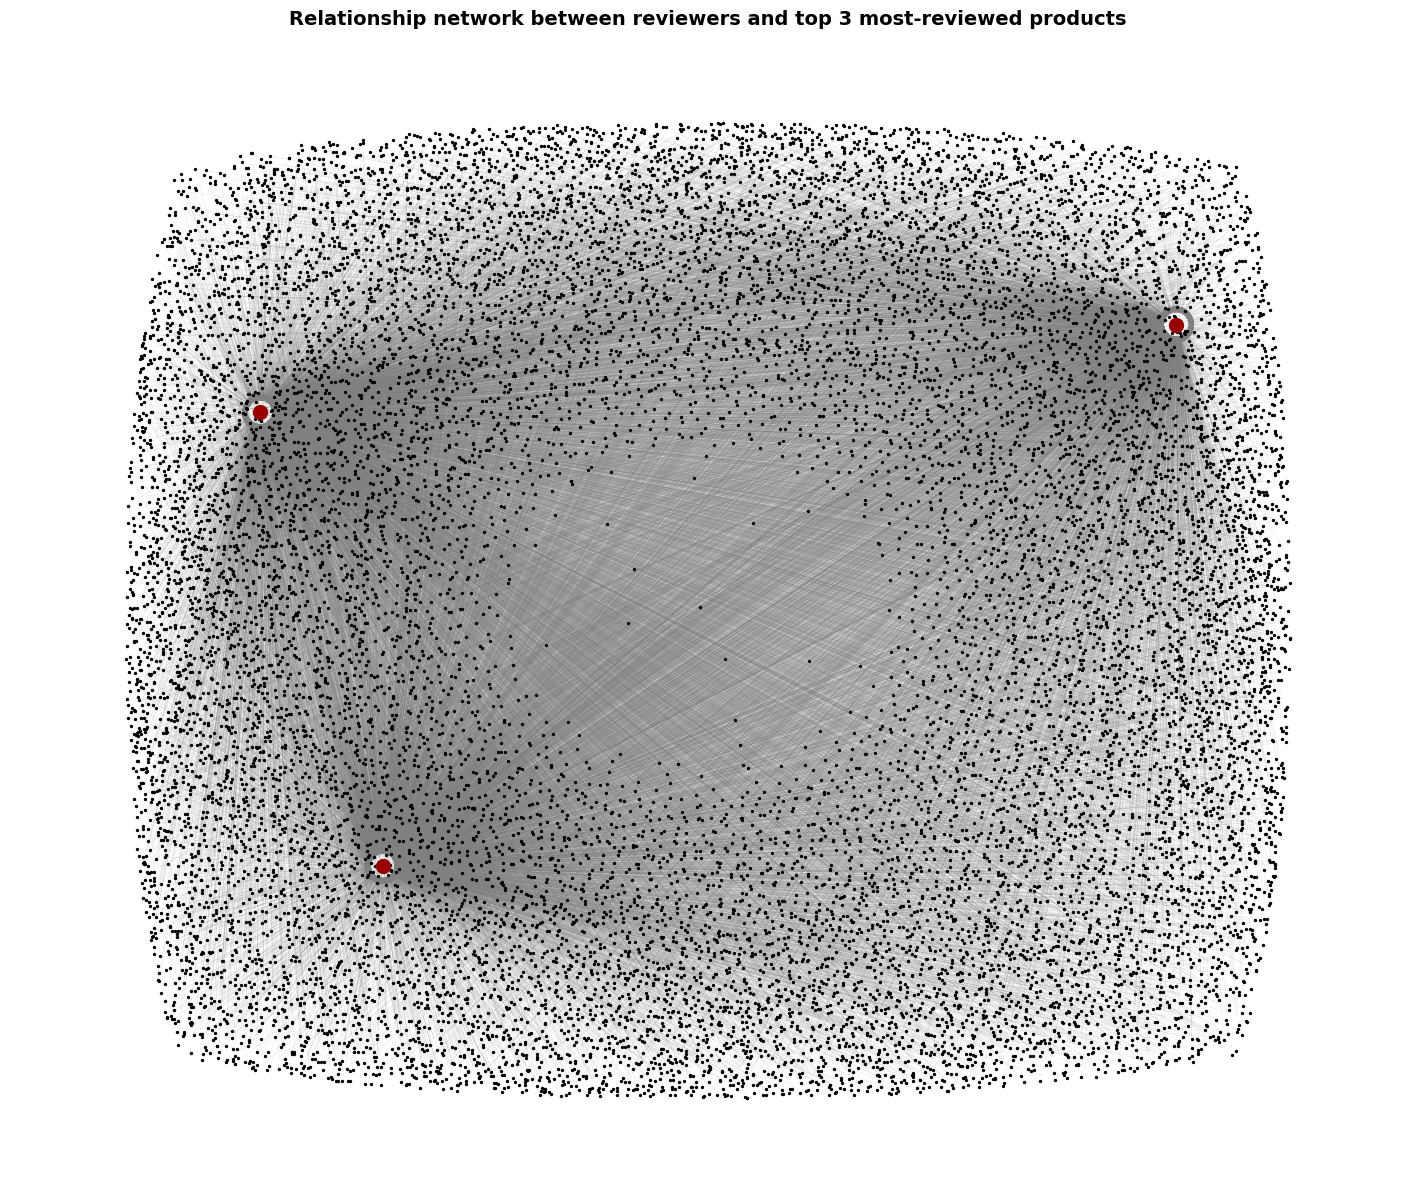

2025-03-29 22:52:41.558334 -- COMPLETE GRAPH CREATION
2025-03-29 22:52:41.620886 -- COMMENCE GRAPH CREATION


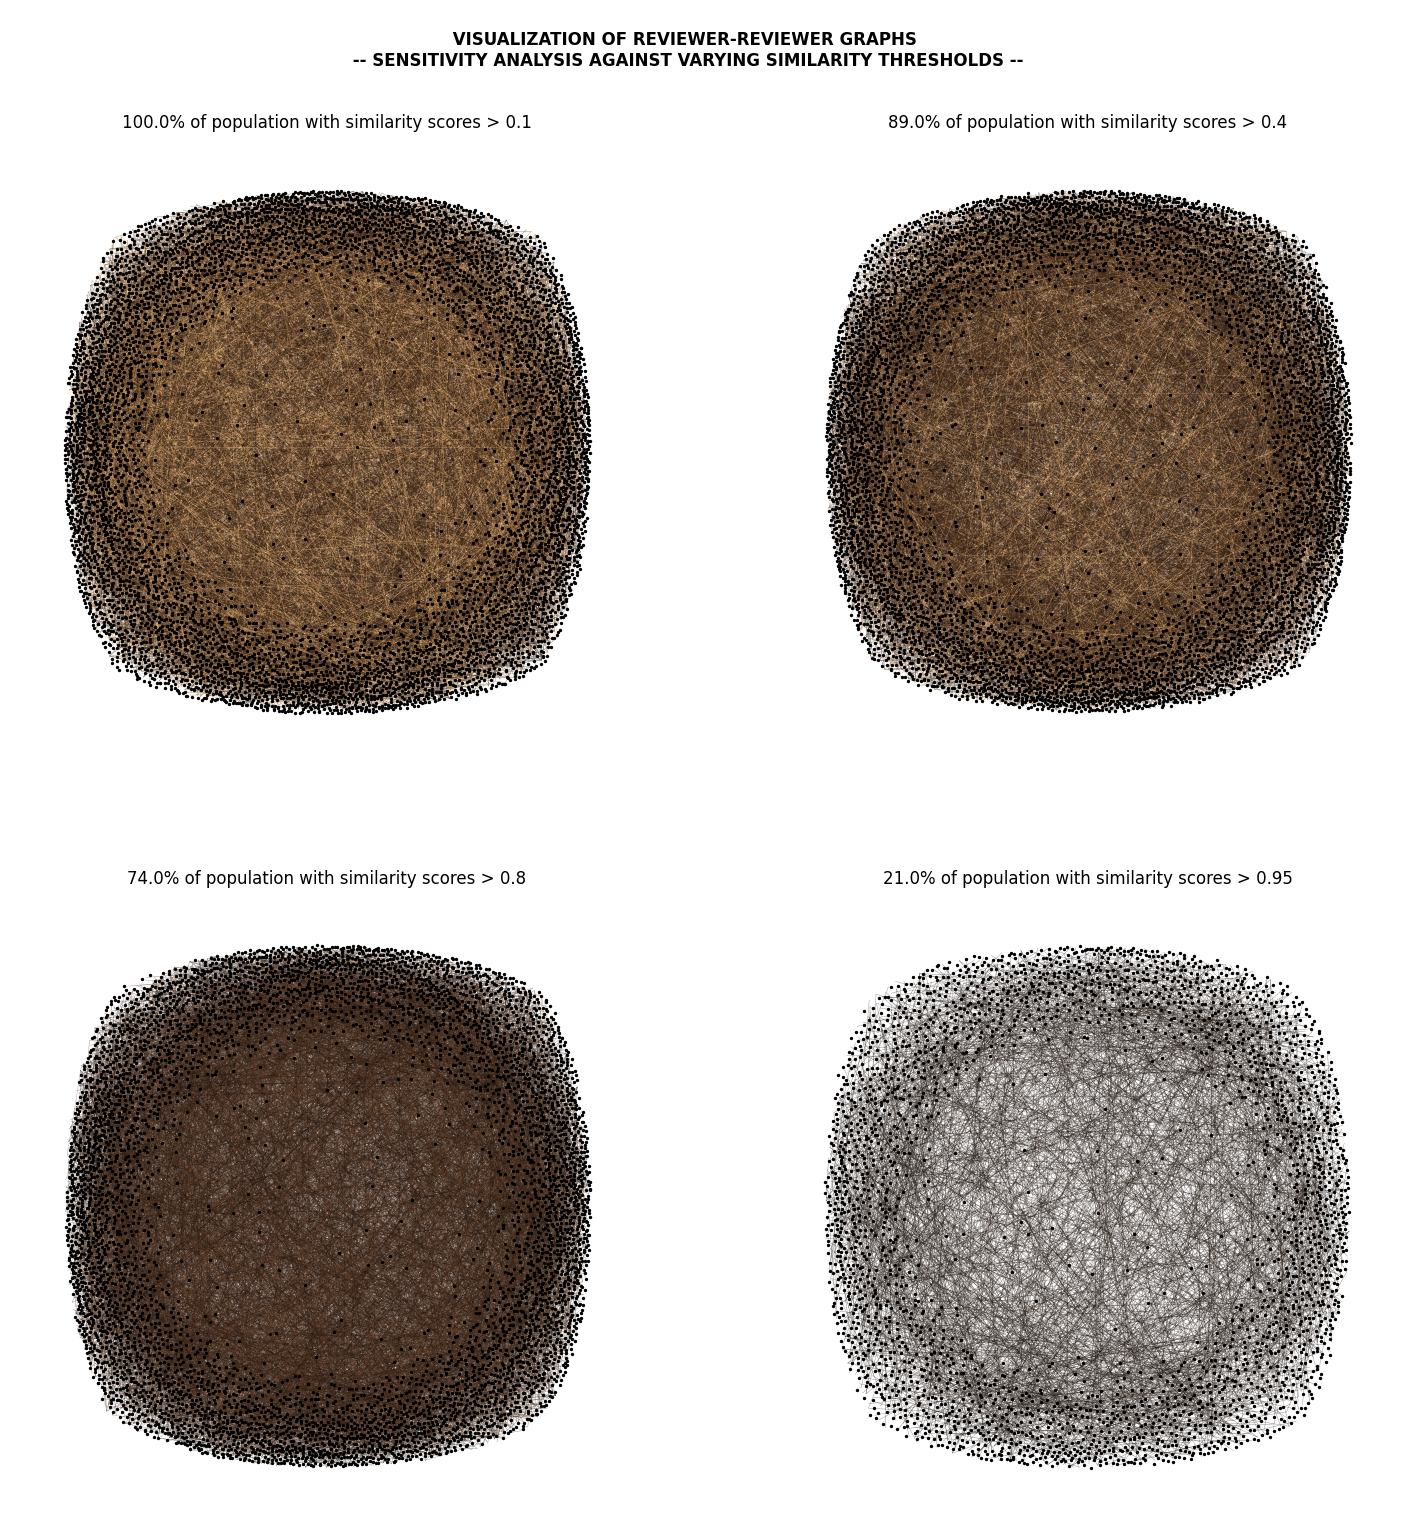

2025-03-29 22:54:15.494107 -- COMPLETE GRAPH CREATION


In [ ]:
# --------------------------------------------------------------------
# --------------------- read similarity file -------------------------
# --------------------------------------------------------------------

similarity_df = pd.read_csv(similarity_path)

# --------------------------------------------------------------------
# --------------------- visualizing product-reviewer graph -----------
# --------------------------------------------------------------------

pdt_reviewer_df = reviewrating_df.merge(reviewcontent_df, on = ['user_id', 'product_id'], how = 'outer') #359052 rows
top_reviewed_pdts = pdt_reviewer_df.groupby('product_id')['user_id'].count().sort_values(ascending = False).head(3).reset_index()['product_id'].tolist()
pdt_reviewer_PLOT = pdt_reviewer_df[pdt_reviewer_df['product_id'].isin(top_reviewed_pdts)].reset_index(drop = True) #79790 for top 30, 40406 for top 10

G = nx.DiGraph()

PRODUCT_colour = '#990000'
CONNECT_colour = '#808080'
REVIEWER_colour = '#000000'

G.add_nodes_from(pdt_reviewer_PLOT["user_id"], color = REVIEWER_colour)
G.add_nodes_from(pdt_reviewer_PLOT["product_id"], color = PRODUCT_colour)
G.add_edges_from([(row["user_id"], row["product_id"]) for index, row in pdt_reviewer_PLOT.iterrows()], color=CONNECT_colour,)

print(datetime.datetime.now(), "-- COMMENCE GRAPH CREATION")

plt.figure(figsize=(18, 15))

pos = nx.spring_layout(G, iterations=3, k =0.5) # Define the layout for node positioning; takes very long
[nx.draw_networkx_nodes(G, pos = pos, nodelist=[node[0]], node_size=2, alpha = 1, node_color = REVIEWER_colour) for node in G.nodes(data='color') if node[1] == REVIEWER_colour]
[nx.draw_networkx_nodes(G, pos = pos, nodelist=[node[0]], node_size=100, alpha = 1, node_color = PRODUCT_colour) for node in G.nodes(data='color') if node[1] == PRODUCT_colour]
[nx.draw_networkx_edges(G, pos = pos, edgelist=[edge], alpha = 0.6, width = 0.1, edge_color = CONNECT_colour) for edge in G.edges(data='color') if edge[2] == CONNECT_colour]

plt.axis('off')
plt.title(f"Relationship network between reviewers and top 3 most-reviewed products", fontsize = 14, fontweight="bold")
plt.savefig(os.path.dirname(os.getcwd()) + f"/data/pdt_reviewer_PLOT.png", bbox_inches='tight')
plt.show()

print(datetime.datetime.now(), "-- COMPLETE GRAPH CREATION")

# --------------------------------------------------------------------
# --------------------- visualizing reviewer-reviewer graph ----------
# --------------------------------------------------------------------

reviewer_reviewer_PLOT = similarity_df[['user_id1','user_id2','similarity_score']]
reviewer_reviewer_PLOT = reviewer_reviewer_PLOT.sample(10000, random_state = 8888).sort_values('similarity_score')

print(datetime.datetime.now(), "-- COMMENCE GRAPH CREATION")

# Create subplot grid
fig, axs = plt.subplots(2, 2, figsize=(18, 18))

norm = Normalize(vmin=0.6, vmax= 1.0)

# Plot each graph in subplots
for ax, threshold in zip(axs.flat, [0.1, 0.4, 0.8, 0.95]):

    reviewer_reviewer_PLOTtemp = reviewer_reviewer_PLOT[reviewer_reviewer_PLOT['similarity_score'] > threshold]
    user_ids = set(reviewer_reviewer_PLOTtemp['user_id1'].tolist() + reviewer_reviewer_PLOTtemp['user_id2'].tolist())
    edge_list = [(row["user_id1"], row["user_id2"],  {'color': plt.cm.copper_r(norm(row["similarity_score"])), 'width': row["similarity_score"] * 3 })
                for _, row in reviewer_reviewer_PLOTtemp.iterrows()]

    G = nx.DiGraph()
    G.add_nodes_from(user_ids, color = REVIEWER_colour)
    G.add_edges_from(edge_list)
    nx.draw_networkx_nodes(G, nx.spring_layout(G, k=0.3, iterations=15),nodelist=user_ids, node_size=2, node_color=REVIEWER_colour, ax=ax)
    nx.draw_networkx_edges(G, nx.spring_layout(G, k=0.3, iterations=15), edgelist=G.edges(), edge_color=[G[u][v]['color'] for u, v in G.edges()], width=0.3, alpha=0.5, arrows=False, ax=ax)

    ax.set_title(f"{round(len(similarity_df[similarity_df['similarity_score'] > threshold]) / len(similarity_df), 2) * 100}% of population with similarity scores > {threshold}", fontsize=12)
    ax.axis('off')

plt.suptitle("\n VISUALIZATION OF REVIEWER-REVIEWER GRAPHS \n -- SENSITIVITY ANALYSIS AGAINST VARYING SIMILARITY THRESHOLDS --", fontsize=12, y=0.95, fontweight="bold")
plt.savefig(os.path.dirname(os.getcwd()) + "/data/reviewer_reviewer_4grid.png", bbox_inches='tight')
plt.show()

print(datetime.datetime.now(), "-- COMPLETE GRAPH CREATION")

In [ ]:
def read_metadata_df(metadata_path):
    """Reading in metadata file"""
    metadata = []
    metadata_file = read_txt_file(metadata_path)
    for lines in metadata_file:
        lines = lines.replace("\n", "")
        lines = lines.split('\t')
        metadata.append(lines)
    metadata_df = pd.DataFrame(metadata, columns = ['user_id', 'product_id', 'rating', 'label', 'date'])
    return metadata_df

def read_reviewcontent_df(reviewcontent_path):
    """Reading in reviewcontent file"""
    reviewcontent_filelist = []
    reviewcontent_file = read_txt_file(reviewcontent_path)
    for lines in reviewcontent_file:
        lines = lines.replace("\n", "")
        lines = lines.split('\t')
        reviewcontent_filelist.append(lines)
    reviewcontent_df = pd.DataFrame(reviewcontent_filelist, columns= ['user_id', 'product_id', 'date', 'review'])
    reviewcontent_df['date'] = pd.to_datetime(reviewcontent_df['date'], format = "%Y-%m-%d")
    return reviewcontent_df

def compute_relevant_files(metadata_df, reviewcontent_df, prior_file_path, N_product=5, N_users=10000, seed=42):
    """
    Pre-processing relevant files to generate reviewer-prior df and relevant similarity edges df.
    """
    unique_user_label_pairs = metadata_df[['user_id', 'label']].drop_duplicates()
    num_unique_pairs = unique_user_label_pairs.shape[0]
    print("Number of unique (user_id, label) pairs:", num_unique_pairs)
    # Assuming unique_user_label_pairs has been created as shown previously
    duplicated_user_ids = unique_user_label_pairs[unique_user_label_pairs['user_id'].duplicated()]['user_id'].unique()
    print("Number of duplicated user_ids:", len(duplicated_user_ids))
    unique_user_label_pairs['user_id'] = unique_user_label_pairs['user_id'].astype(int)
    unique_user_label_pairs['label'] = unique_user_label_pairs['label'].astype(int)
    # Assuming unique_user_label_pairs has been created as shown previously
    first_row_per_user_id = unique_user_label_pairs.drop_duplicates(subset='user_id', keep='first')
    first_row_per_user_id = first_row_per_user_id.rename(columns={'user_id':'user'})

    ## Keep first N products
    similarity_df = pd.read_pickle(similarity_path_final)
    reviewer_prior_df = pd.read_csv(prior_file_path, delimiter=",")
    reviewer_prior_df = reviewer_prior_df.rename(columns={'userid':'user'})
    keep_product = list(reviewcontent_df.product_id.unique())[:N_product]
    keep_user_id = list(reviewcontent_df[reviewcontent_df['product_id'].isin(keep_product)]['user_id'].unique())
    print(f"Unique user id : {len(keep_user_id)}")
    keep_user_id = [int(x) for x in keep_user_id]
    reviewer_prior_df_product = reviewer_prior_df[reviewer_prior_df['user'].isin(keep_user_id)]
    print("After filtering : ", reviewer_prior_df_product.shape)
    # reviewer_prior_df = reviewer_prior_df.merge(first_row_per_user_id,how='left',on='user')
    # print("After merge : ", reviewer_prior_df.shape)
    similarity_df_product = similarity_df[(similarity_df['user_id1'].isin(keep_user_id)) & (similarity_df['user_id2'].isin(keep_user_id)) ]
    print("number of edges : ", similarity_df_product.shape)

    ## Keep N users
    similarity_df = pd.read_pickle(similarity_path_final)
    reviewer_prior_df = pd.read_csv(prior_file_path, delimiter=",")
    reviewer_prior_df = reviewer_prior_df.rename(columns={'userid':'user'})
    reviewer_prior_df_users = reviewer_prior_df.sample(n=N_users, random_state=seed)
    print("After filtering : ", reviewer_prior_df_users.shape)
    # reviewer_prior_df = reviewer_prior_df.merge(first_row_per_user_id,how='left',on='user')
    # print("After merge : ", reviewer_prior_df.shape)
    keep_user_id = list(reviewer_prior_df_users.user.unique())
    similarity_df_users = similarity_df[(similarity_df['user_id1'].isin(keep_user_id)) & (similarity_df['user_id2'].isin(keep_user_id)) ]
    print("number of edges : ", similarity_df_users.shape)

    ## stack together and filter for unique and merge.
    reviewer_prior_df = pd.concat([reviewer_prior_df_product, reviewer_prior_df_users])
    reviewer_prior_df = reviewer_prior_df.drop_duplicates()
    similarity_df = pd.concat([similarity_df_product, similarity_df_users])
    similarity_df = similarity_df.drop_duplicates()
    print("number of edges : ", similarity_df.shape)
    reviewer_prior_df = reviewer_prior_df.merge(first_row_per_user_id,how='left',on='user')
    print("After merge : ", reviewer_prior_df.shape)

    return reviewer_prior_df, similarity_df

In [ ]:
# -------------------------------
# STEP 2: Build Reviewer–Reviewer Graph
# -------------------------------

def build_reviewer_graph(reviewer_prior_df, similarity_df, threshold=0.1):
    """Construct an undirected reviewer graph with node priors and edge weights."""
    G = nx.Graph()
    # Add nodes with individual prior attribute
    for idx, row in reviewer_prior_df.iterrows():
        G.add_node(row['user'], prior=row['prior'])
    # Add edges if similarity exceeds threshold
    for idx, row in similarity_df.iterrows():
        if row['collusiveness_score'] > threshold:
            G.add_edge(row['user_id1'], row['user_id2'], weight=row['collusiveness_score'])
    return G

# G_reviewer = build_reviewer_graph(reviewer_prior_df, similarity_df, threshold=0.1)

# -------------------------------
# STEP 2: Build Reviewer–Reviewer Graph in parallel
# -------------------------------
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def build_reviewer_graph_fast(reviewer_prior_df, similarity_df, threshold=0.1, max_workers=8):
    G = nx.Graph()

    # -------------------
    # Add all nodes (vectorized)
    # -------------------
    nodes = list(zip(reviewer_prior_df['user'], reviewer_prior_df['prior']))
    G.add_nodes_from((user, {'prior': prior}) for user, prior in nodes)

    print(f"✅ Added {len(nodes):,} reviewer nodes.")

    # -------------------
    # Filter and extract edges (vectorized)
    # -------------------
    user_ids = similarity_df[['user_id1', 'user_id2']].astype(int)
    similarity_df['user_id_min'] = user_ids.min(axis=1)
    similarity_df['user_id_max'] = user_ids.max(axis=1)

    # Filter for user_id pair that only exists in the graph.


    # Filter by threshold
    filtered_edges = similarity_df[similarity_df['collusiveness_score'] > threshold][
        ['user_id_min', 'user_id_max', 'collusiveness_score']
    ].rename(columns={
        'user_id_min': 'user_id1',
        'user_id_max': 'user_id2'
    })
    edge_list = list(filtered_edges.itertuples(index=False, name=None))  # [(u1, u2, score), ...]

    print(f"⏳ Adding {len(edge_list):,} edges in parallel...")

    # -------------------
    # Parallel edge addition
    # -------------------
    def add_edge_batch(edge_batch):
        for u, v, weight in edge_batch:
            G.add_edge(u, v, weight=weight)

    chunk_size = len(edge_list) // max_workers
    chunks = [edge_list[i:i + chunk_size] for i in range(0, len(edge_list), chunk_size)]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(add_edge_batch, chunks), total=len(chunks)))

    return G

# ------------- Define Prior file path -------
prior_file_path = os.path.dirname(os.getcwd()) + "/Project/data/YelpNYC/prior_no_text.csv"

N_product = 2
N_users = 5000
COLLUSIVE_THRESHOLD = 0.2
ALPHA = 1
seed = 42

metadata_df = read_metadata_df(metadata_path)
reviewcontent_df = read_reviewcontent_df(reviewcontent_path)
reviewer_prior_df, similarity_df = compute_relevant_files(metadata_df, reviewcontent_df, prior_file_path, N_product=N_product, N_users=N_users, seed=seed)

G_reviewer = build_reviewer_graph_fast(
    reviewer_prior_df,
    similarity_df,
    threshold=COLLUSIVE_THRESHOLD,
    max_workers=16  # scale based on your CPU
)


Number of unique (user_id, label) pairs: 160882
Number of duplicated user_ids: 657
Unique user id : 462
After filtering :  (462, 2)
number of edges :  (58603, 3)
After filtering :  (5000, 2)
number of edges :  (176125, 3)
number of edges :  (234700, 3)
After merge :  (5451, 3)
✅ Added 5,451 reviewer nodes.
⏳ Adding 234,696 edges in parallel...


100%|██████████| 17/17 [00:00<00:00, 257412.16it/s]


In [ ]:
# -------------------------------
# STEP 3: Compute Group-Based (NT) Prior
# -------------------------------
def compute_group_nt(G):
    """
    Use a community detection algorithm (e.g., greedy modularity communities)
    to compute a group-based prior (Neighbor Tightness, NT) for each node.
    """
    communities = list(nx.algorithms.community.greedy_modularity_communities(G))
    nt_dict = {}
    for community in communities:
        community = list(community)
        n = len(community)
        if n < 2:
            for node in community:
                nt_dict[node] = 0.0
            continue
        sum_weight = 0
        count = 0
        # Sum up the weights for edges within the community
        for i in range(n):
            for j in range(i+1, n):
                if G.has_edge(community[i], community[j]):
                    sum_weight += G[community[i]][community[j]]['weight']
                    count += 1
        avg_weight = sum_weight / count if count > 0 else 0
        # Apply a sigmoid factor based on community size: penalize very small groups.
        sigmoid = 1 / (1 + np.exp(-(n - 2)))
        nt_value = avg_weight * sigmoid
        for node in community:
            nt_dict[node] = nt_value
    return nt_dict

group_nt = compute_group_nt(G_reviewer)

In [ ]:
# -------------------------------
# STEP 4: Combine Individual and Group Priors
# -------------------------------
def combine_priors(individual_prior, group_prior, alpha=0.5):
    """
    Combine individual review-based priors and group (NT) priors.
    alpha is the weight for individual prior; (1 - alpha) for group prior.
    """
    combined = {}
    for node in individual_prior:
        combined[node] = alpha * individual_prior[node] + (1 - alpha) * group_prior.get(node, 0)
    return combined

# Create dictionary from reviewer_prior_df for individual priors
individual_prior = dict(zip(reviewer_prior_df['user'], reviewer_prior_df['prior']))
combined_prior = combine_priors(individual_prior, group_nt, alpha=ALPHA)

# Update graph nodes with the combined prior
for node in G_reviewer.nodes():
    G_reviewer.nodes[node]['prior'] = combined_prior.get(node, individual_prior.get(node, 0))

In [ ]:
# -------------------------------
# STEP 5a: MRF Inference via Loopy Belief Propagation
# -------------------------------
def node_potential(prior, x):
    """
    Node potential based on prior.
    For state x: +1 means benign, -1 means spam.
    """
    if x == +1:
        return 1 - prior
    elif x == -1:
        return prior

def edge_potential(weight, x_i, x_j):
    """Edge potential: exp(x_i * x_j * weight)"""
    return math.exp(x_i * x_j * weight)

def run_lbp(G, max_iter=50, tol=1e-3):
    """
    Run loopy belief propagation (sum-product) on graph G.
    G is expected to have:
      - Node attribute 'prior'
      - Edge attribute 'weight'
    Returns a dictionary of beliefs for each node.
    """
    # Initialize messages m[i][j] for each directed edge i->j
    messages = {}
    for i in G.nodes():
        messages[i] = {}
        for j in G.neighbors(i):
            messages[i][j] = {+1: 1.0, -1: 1.0}
    states = [+1, -1]
    for it in range(max_iter):
        print(f"Running {it+1} iteration now.")
        max_diff = 0
        new_messages = {}
        for i in G.nodes():
            new_messages[i] = {}
            for j in G.neighbors(i):
                new_msg = {}
                for x_j in states:
                    sum_val = 0
                    for x_i in states:
                        psi_i = node_potential(G.nodes[i]['prior'], x_i)
                        psi_ij = edge_potential(G.edges[i, j]['weight'], x_i, x_j)
                        prod = 1
                        for k in G.neighbors(i):
                            if k == j:
                                continue
                            prod *= messages[k][i][x_i]
                        sum_val += psi_i * psi_ij * prod
                    new_msg[x_j] = sum_val
                # Normalize the new message
                s = new_msg[+1] + new_msg[-1]
                if s > 0:
                    new_msg[+1] /= s
                    new_msg[-1] /= s
                new_messages[i][j] = new_msg
                # Compute maximum change for convergence check
                diff = max(abs(new_msg[+1] - messages[i][j][+1]), abs(new_msg[-1] - messages[i][j][-1]))
                max_diff = max(max_diff, diff)
        messages = new_messages
        if max_diff < tol:
            print(f"LBP converged after {it+1} iterations")
            break

    # Compute beliefs for each node
    beliefs = {}
    for i in G.nodes():
        belief = {}
        for x in states:
            psi_i = node_potential(G.nodes[i]['prior'], x)
            prod = 1
            for k in G.neighbors(i):
                prod *= messages[k][i][x]
            belief[x] = psi_i * prod
        # Normalize beliefs
        s = belief[+1] + belief[-1]
        if s > 0:
            belief[+1] /= s
            belief[-1] /= s
        beliefs[i] = belief
    return beliefs

beliefs = run_lbp(G_reviewer, max_iter=50, tol=1e-3)

Running 1 iteration now.
Running 2 iteration now.
Running 3 iteration now.
Running 4 iteration now.
Running 5 iteration now.
Running 6 iteration now.
Running 7 iteration now.
LBP converged after 7 iterations


In [ ]:
# -------------------------------
# STEP 5b: Approximate Inference via Gibbs Sampling
# -------------------------------
import random
def gibbs(G, log_interval=10, num_sweeps=1500, burn_in=300):
    nodes = list(G.nodes())
    idx   = {n:i for i,n in enumerate(nodes)}
    N     = len(nodes)

    # --- 2) Extract and clip priors + compute log‑odds ---
    eps    = 1e-6
    priors = np.array([G.nodes[n]['prior'] for n in nodes], dtype=np.float32)
    priors = np.clip(priors, eps, 1-eps)
    log_odds = np.log(priors / (1-priors))

    # --- 3) Precompute neighbor arrays ---
    neighbors_idx = []
    neighbors_wts = []
    for n in nodes:
        nbrs = list(G.neighbors(n))
        neighbors_idx.append(np.array([idx[m] for m in nbrs], dtype=np.int32))
        neighbors_wts.append(np.array([G.edges[n,m]['weight'] for m in nbrs], dtype=np.float32))

    # --- 4) Gibbs params + diagnostics storage ---
    beta         =   0.07   # <1 to soften coupling, >1 to sharpen

    counts    = np.zeros((N,2), dtype=np.int64)   # [:,0]=#(+1), [:,1]=#(−1)
    mag_trace = np.zeros(num_sweeps, dtype=np.float32)

    # for interim marginal snapshots
    snapshots = {}

    # --- 5) Initialize state at random ---
    state = np.random.choice([+1,-1], size=N)

    # --- 6) Fast Gibbs sweeps with monitoring ---
    for sweep in tqdm(range(num_sweeps), desc="Gibbs Sweeps"):
        for i in range(N):
            # local field with temperature scaling
            nbrs = neighbors_idx[i]
            h    = beta * neighbors_wts[i].dot(state[nbrs])

            # combine with prior log‑odds (Ising factor 2)
            h_total = h + 0.5 * log_odds[i]
            p_plus  = 1.0 / (1.0 + np.exp(-2.0 * h_total))

            # sample spin
            state[i] = +1 if random.random() < (1 - p_plus) else -1

        # record magnetization
        mag_trace[sweep] = state.mean()

        # tally after burn‑in
        if sweep >= burn_in:
            plus = (state == +1)
            counts[plus, 0]  += 1
            counts[~plus, 1] += 1

        # snapshot marginals every log_interval
        if (sweep+1) % log_interval == 0 or sweep == num_sweeps-1:
            tot = max(1, sweep - burn_in + 1)
            margs = counts[:,:].astype(np.float32) / tot    # shape (N,2)
            # store the distribution of P(+1)
            snapshots[sweep] = np.percentile(margs[:,0], [0,25,50,75,100])

    # --- 7) Build final marginals ---
    tot = num_sweeps - burn_in
    margs = counts.astype(np.float32) / tot    # shape (N,2)
    beliefs = { nodes[i]: margs[i] for i in range(N) }
    return beliefs

gibbs_beliefs = gibbs(G_reviewer)

Gibbs Sweeps: 100%|██████████| 1500/1500 [00:17<00:00, 87.46it/s]


In [ ]:
# -------------------------------
# STEP 6: Rank and Evaluate Reviewers & Groups
# -------------------------------
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def compute_accuracy(beliefs, reviewer_prior_df):
    # --- PREDICTION + EVALUATION ---
    result_df = pd.DataFrame([
        {
            "user": node,
            "predicted_label": -1 if beliefs[node][-1] > 0.5 else 1,
            "spam_score": beliefs[node][-1]
        } for node in beliefs
    ])

    # Merge ground truth labels
    result_df = result_df.merge(reviewer_prior_df[['user', 'label']], on='user',how='left')

    # Compute accuracy
    accuracy = (result_df['predicted_label'] == result_df['label']).mean()
    print("Predictions:\n", result_df)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")
    return result_df, accuracy * 100

def compute_classification_metrics(beliefs, reviewer_prior_df):
    """
    Compute accuracy, precision, recall, F1, and AUC for belief-based predictions.
    """
    # Prepare prediction dataframe
    result_df = pd.DataFrame([
        {
            "user": node,
            "predicted_label": -1 if beliefs[node][-1] > 0.5 else 1,
            "spam_score": beliefs[node][-1]
        } for node in beliefs
    ])

    # Merge with ground truth
    result_df = result_df.merge(reviewer_prior_df[['user', 'label']], on='user', how='left')

    # Drop rows with missing labels (if any)
    result_df = result_df.dropna(subset=['label'])

    # Extract ground truth and predictions
    y_true = result_df['label']
    y_pred = result_df['predicted_label']
    y_score = result_df['spam_score']  # probability of being spam (-1)

    # Compute metrics
    accuracy = (y_pred == y_true).mean()
    precision = precision_score(y_true, y_pred, pos_label=-1)
    recall = recall_score(y_true, y_pred, pos_label=-1)
    f1 = f1_score(y_true, y_pred, pos_label=-1)

    # AUC requires at least one positive and one negative label
    try:
        auc = roc_auc_score((y_true == -1).astype(int), y_score)
    except ValueError:
        auc = float('nan')

    # Display results
    print("Predictions:\n", result_df)
    print(f"\nAccuracy:  {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    return result_df, {
        'accuracy': accuracy * 100,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

Predictions:
         user  predicted_label     spam_score  label
0        923                1   0.000000e+00     -1
1        924                1  1.164604e-142     -1
2        925                1   0.000000e+00     -1
3        926                1  2.000597e-154     -1
4        927                1   0.000000e+00     -1
...      ...              ...            ...    ...
5446  145053                1   5.217746e-05      1
5447  127080                1   1.380531e-48      1
5448   61690                1   7.261251e-25      1
5449   91874                1   1.257301e-08      1
5450   33661                1   2.997860e-65      1

[5451 rows x 4 columns]

Accuracy: 82.77%
Predictions:
         user  predicted_label     spam_score  label
0        923                1   0.000000e+00     -1
1        924                1  1.164604e-142     -1
2        925                1   0.000000e+00     -1
3        926                1  2.000597e-154     -1
4        927                1   0.000000e+00 

/Users/daryltay/miniconda3/envs/cs5340/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


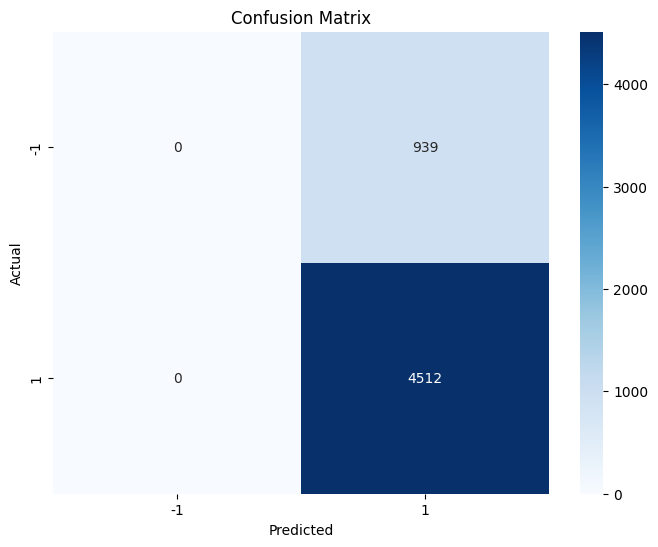

In [ ]:
# -------------------------------
# STEP 6a: Evaluation for LBP Inference Result
# -------------------------------

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

result_df, accuracy = compute_accuracy(beliefs, reviewer_prior_df)
# Compute the confusion matrix
cm = confusion_matrix(result_df['label'], result_df['predicted_label'], labels=[-1, 1])
# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['-1', '1'], columns=[ '-1', '1'])
result_df, metrics_dict = compute_classification_metrics(beliefs, reviewer_prior_df)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Predictions:
         user  predicted_label  spam_score  label
0        923                1    0.024167     -1
1        924               -1    0.998333     -1
2        925                1    0.000000     -1
3        926               -1    0.997500     -1
4        927                1    0.002500     -1
...      ...              ...         ...    ...
5446  145053                1    0.332500      1
5447  127080               -1    0.587500      1
5448   61690               -1    0.560000      1
5449   91874                1    0.287500      1
5450   33661               -1    0.680000      1

[5451 rows x 4 columns]

Accuracy: 67.75%
Predictions:
         user  predicted_label  spam_score  label
0        923                1    0.024167     -1
1        924               -1    0.998333     -1
2        925                1    0.000000     -1
3        926               -1    0.997500     -1
4        927                1    0.002500     -1
...      ...              ...         ...    ..

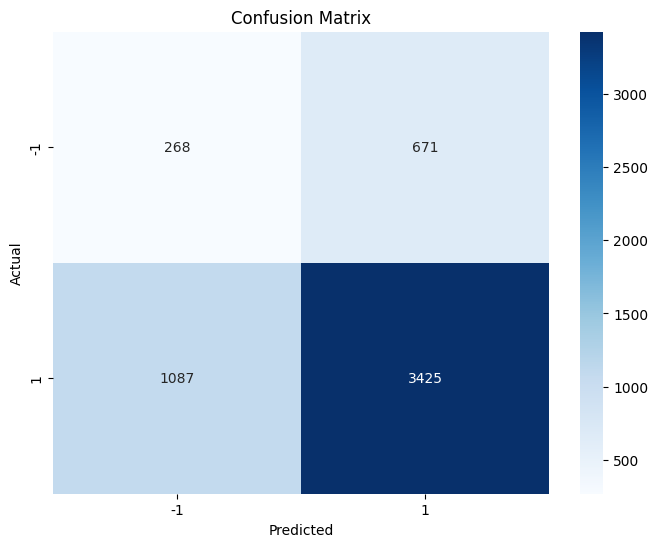

In [ ]:
# -------------------------------
# STEP 6b: Evaluation for Gibbs Sampling Result
# -------------------------------

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

result_df, accuracy = compute_accuracy(gibbs_beliefs, reviewer_prior_df)
# Compute the confusion matrix
cm = confusion_matrix(result_df['label'], result_df['predicted_label'], labels=[-1, 1])
# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['-1', '1'], columns=[ '-1', '1'])
result_df, metrics_dict = compute_classification_metrics(gibbs_beliefs, reviewer_prior_df)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()